### Imports

In [1]:
import pandas as pd
import torch
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### Read Pre-processed Drug-Side-Effect List 

In [2]:
df_all_se = pd.read_csv('prep_data/drug_all_se_pubchem.csv')
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0151828', 'C0030193', 'C0042109', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."


In [3]:
df_all_se.columns

Index(['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'mw', 'mf', 'polararea', 'complexity', 'xlogp', 'heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds', 'inchi', 'isosmiles',
       'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [4]:
drug_pub_prop_cols = [ 'mw', 'polararea', 'complexity','heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds']

In [5]:
df_all_se[drug_pub_prop_cols].isnull().sum()

mw            0
polararea     0
complexity    0
heavycnt      0
hbonddonor    0
hbondacc      0
rotbonds      0
dtype: int64

### Create Transformation Mapping for drug and side-effect

In [6]:
STITCH_TO_ID_DICT = {id: idx for idx, id in enumerate(df_all_se['STITCH ID STEREO'])}
ID_TO_STITCH_DICT = {v: k for k, v in STITCH_TO_ID_DICT.items()}

In [7]:
STITCHID_TO_PUBPPROP_DICT = {idx: _ for idx, (stid, _) in enumerate(zip(df_all_se['STITCH ID STEREO'], df_all_se[drug_pub_prop_cols].values))}


In [8]:
# Create a flattened list of unique meddra term concept id
column_list = df_all_se['MEDRA TERM UMLS CONCEPT ID'].tolist()
unique_values = list(set([item for sublist in column_list for item in eval(sublist)]))
unique_values.sort()
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(unique_values)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

In [9]:
# assert if df stitch id stereo is unique
assert len(df_all_se['STITCH ID STEREO'].unique()) == len(df_all_se['STITCH ID STEREO'])

### Create HeteroData

In [10]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

In [11]:

drug_node_features = torch.stack([torch.tensor(_, dtype=torch.float) for _ in df_all_se[drug_pub_prop_cols].values])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print("Before", drug_node_features.shape)
drug_node_features = scaler.fit_transform(drug_node_features)
print('After MinMax', drug_node_features.shape)
drug_node_features = torch.tensor(drug_node_features, dtype=torch.float)

# # Create a dictionary of node features
# drug_node_features = torch.tensor(np.zeros((len(df_all_se['STITCH ID STEREO']),881)))
# side_effect_node_features = torch.tensor(np.zeros((len(unique_values),881)))


# print('drug_nodes', drug_node_features.shape)
# print('side_effect_nodes', side_effect_node_features.shape)

Before torch.Size([1326, 7])
After MinMax (1326, 7)


In [12]:
# create edge index for drug-side effect from multi-label column_list
edge_index = []
for idx, row in df_all_se.iterrows():
    for se in eval(row['MEDRA TERM UMLS CONCEPT ID']):
        edge_index.append([STITCH_TO_ID_DICT[row['STITCH ID STEREO']], MEDRAID_TO_ID_DICT[se]])
edge_index = torch.tensor(edge_index).T


# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', edge_index.shape)
print('edge_index', edge_index)

edge_index torch.Size([2, 129851])
edge_index tensor([[   0,    0,    0,  ..., 1325, 1325, 1325],
        [1091,  657,  889,  ...,  673,    2,  837]])


In [13]:
# # sanity check
# df_all_se.head(1)

In [14]:
# STITCH_TO_ID_DICT['CID000000119']

In [15]:
# MEDRAID_TO_ID_DICT['C0151828'], MEDRAID_TO_ID_DICT['C0030193'], MEDRAID_TO_ID_DICT['C0042109'], MEDRAID_TO_ID_DICT['C0002994']

In [16]:
# Create a heterograph with 2 types of nodes: drug and side effect
data = HeteroData()

# Add nodes
data['drug'].node_id = torch.arange(drug_node_features.shape[0])
data['side_effect'].node_id = torch.arange(len(unique_values))

# Add node features
data['drug'].x = drug_node_features

# Add edges
data['drug', 'side_effect'].edge_index = edge_index

print(data)

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)


#### Hetero Data Viz

In [37]:
# # Full Graph View
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# from torch_geometric.data import HeteroData


# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()

In [38]:
# # Plot random number of edges and all associated nodes
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData

# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Define the number of random edges you want to visualize
# num_random_edges = 10

# # Randomly select a subset of edges
# random_edge_indices = random.sample(range(data['drug', 'side_effect'].edge_index.shape[1]), num_random_edges)

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# # sample drug_nodes to have only nodes within random_edge_indices
# drug_nodes = np.unique(data['drug', 'side_effect'].edge_index[0, random_edge_indices].numpy())
# side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, random_edge_indices].numpy())


# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index[:, random_edge_indices]
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()


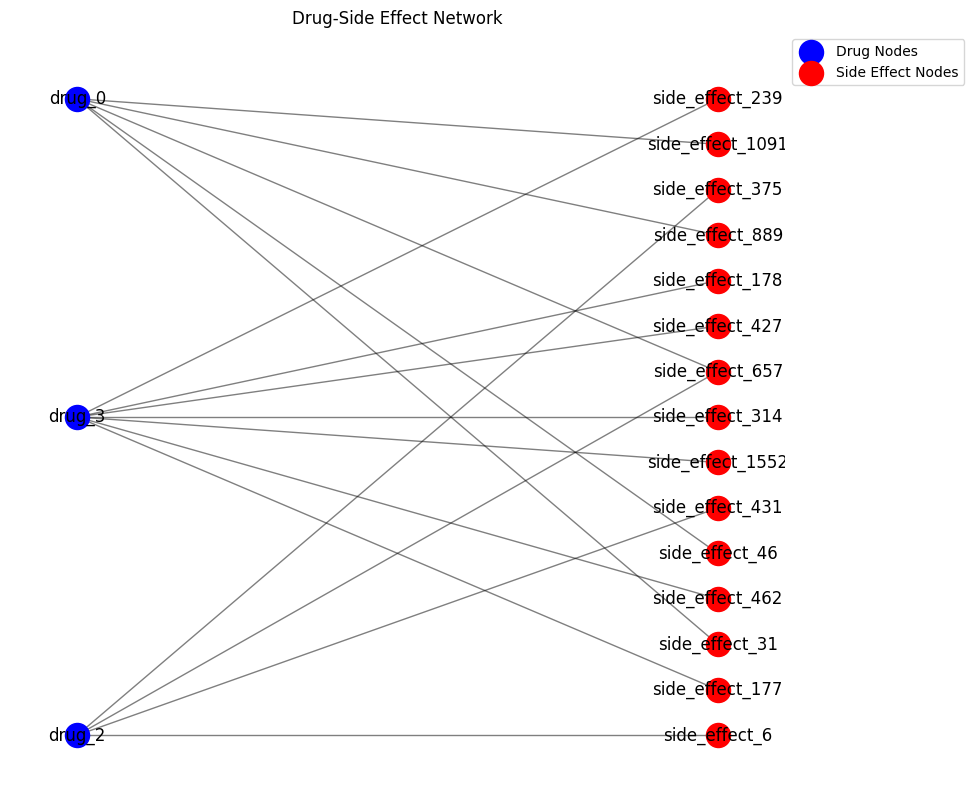

In [26]:
# plot for selected list of drug_id and all associated side effects
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random
from torch_geometric.data import HeteroData

# Convert heterograph to NetworkX graph
graph = nx.Graph()

# list of drug_id to visualize all its associated side effects
drug_id_list = [0, 2, 3]

# associated possible unique side effects using edge_index when drug_id is in drug_id_list
side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list)].numpy())

# filter out edges that are between drug_id_list and side_effect_nodes
drug_edges = data['drug', 'side_effect'].edge_index[:, np.isin(data['drug', 'side_effect'].edge_index[0], drug_id_list) & np.isin(data['drug', 'side_effect'].edge_index[1], side_effect_nodes)]

drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# Add nodes to the NetworkX graph
graph.add_nodes_from(drug_nodes_unique, node_type='drug')
graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# Add edges to the NetworkX graph
for i in range(drug_edges.shape[1]):
    source = drug_edges[0, i].item()
    target = drug_edges[1, i].item()
    source_id = f"drug_{source}"
    target_id = f"side_effect_{target}"
    graph.add_edge(source_id, target_id)

# Visualize the graph using NetworkX
# pos = nx.spring_layout(graph, seed=1)  # Compute node positions
pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions
# Separate nodes by type for different visualization colors
drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# Draw nodes with different colors based on type
nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

# Draw edges with different colors based on type

nx.draw_networkx_edges(graph, pos, edge_color='black', width=1.0, alpha=0.5)

# Draw edges
# nx.draw_networkx_edges(graph, pos)

# Draw node labels
node_labels = {n: str(n) for n in graph.nodes()}
nx.draw_networkx_labels(graph, pos, labels=node_labels)

# Display the graph
plt.axis('off')
# increase figure size
plt.gcf().set_size_inches(10, 10)
# position legend to the right of the graph
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Drug-Side Effect Network')
plt.show()


In [40]:
# graph.nodes()
# # link a map to most common drug_name and side_effect_name

### Hetero Link Prediction task

In [17]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] }
)

In [18]:
import torch_geometric.transforms as T
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

In [19]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={ edge_index=[2, 129851] },
  (side_effect, rev_to, drug)={ edge_index=[2, 129851] }
)

### Define Edge level Train Split

In [20]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('drug', 'to', 'side_effect'),
    rev_edge_types=('side_effect', 'rev_to', 'drug'), 
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)


Training data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={
    edge_index=[2, 72717],
    edge_label=[31164],
    edge_label_index=[2, 31164]
  },
  (side_effect, rev_to, drug)={ edge_index=[2, 72717] }
)

Validation data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, to, side_effect)={
    edge_index=[2, 103881],
    edge_label=[38955],
    edge_label_index=[2, 38955]
  },
  (side_effect, rev_to, drug)={ edge_index=[2, 103881] }
)


### Define Mini-batch Loader

In [98]:
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-1.12.1+cu117.html

In [21]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader.link_neighbor_loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["drug", "to", "side_effect"].edge_label_index
edge_label = train_data["drug", "to", "side_effect"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("drug", "to", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1231],
    x=[1231, 7],
    n_id=[1231]
  },
  side_effect={
    node_id=[1594],
    n_id=[1594]
  },
  (drug, to, side_effect)={
    edge_index=[2, 12798],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[12798],
    input_id=[128]
  },
  (side_effect, rev_to, drug)={
    edge_index=[2, 13286],
    e_id=[13286]
  }
)


/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


### Creating a Heterogeneous Link-level GNN

In [22]:
sampled_data["drug"].num_nodes

1231

In [23]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.nn import LayerNorm, BatchNorm

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index)+self.lin1(x))
        x = self.conv2(x, edge_index) + self.lin2(x)
        return x

In [24]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

In [31]:
class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        # self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.drug_feat_layernorm = LayerNorm(7)
        self.drug_lin = torch.nn.Linear(7, hidden_channels)
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, hidden_channels)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

        # xavier initialization of embedding matrices:
        # for emb in [self.drug_emb, self.seff_emb]:
        #     torch.nn.init.xavier_uniform_(emb.weight)        

    def forward(self, data: HeteroData) -> Tensor:
        # layer normalization of input features:
        x_dict = {
            "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
            "side_effect": self.seff_emb(data["side_effect"].node_id)
        }



        # x_dict = {
        #   "drug": self.drug_lin(data["drug"].x) + self.drug_emb(data["drug"].node_id),
        #   "side_effect": self.seff_emb(data["side_effect"].node_id),
        # } 

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "to", "side_effect"].edge_label_index,
        )

        return pred

        
model = Model(hidden_channels=64)

print(model)

Model(
  (drug_feat_layernorm): LayerNorm(7, affine=True, mode=graph)
  (drug_lin): Linear(in_features=7, out_features=64, bias=True)
  (drug_emb): Embedding(1326, 64)
  (seff_emb): Embedding(2061, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (drug__to__side_effect): SAGEConv(64, 64, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(64, 64, aggr=mean)
    )
    (lin1): ModuleDict(
      (drug): Linear(in_features=64, out_features=64, bias=True)
      (side_effect): Linear(in_features=64, out_features=64, bias=True)
    )
    (conv2): ModuleDict(
      (drug__to__side_effect): SAGEConv(64, 64, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(64, 64, aggr=mean)
    )
    (lin2): ModuleDict(
      (drug): Linear(in_features=64, out_features=64, bias=True)
      (side_effect): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (classifier): Classifier()
)


In [32]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 11):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 244/244 [00:07<00:00, 31.23it/s]


Epoch: 001, Loss: 0.5559


100%|██████████| 244/244 [00:07<00:00, 30.71it/s]


Epoch: 002, Loss: 0.4202


100%|██████████| 244/244 [00:07<00:00, 30.53it/s]


Epoch: 003, Loss: 0.3974


100%|██████████| 244/244 [00:07<00:00, 32.46it/s]


Epoch: 004, Loss: 0.3848


100%|██████████| 244/244 [00:07<00:00, 32.59it/s]


Epoch: 005, Loss: 0.3791


100%|██████████| 244/244 [00:07<00:00, 32.48it/s]


Epoch: 006, Loss: 0.3682


100%|██████████| 244/244 [00:07<00:00, 32.69it/s]


Epoch: 007, Loss: 0.3626


100%|██████████| 244/244 [00:07<00:00, 32.09it/s]


Epoch: 008, Loss: 0.3607


100%|██████████| 244/244 [00:07<00:00, 32.33it/s]


Epoch: 009, Loss: 0.3550


100%|██████████| 244/244 [00:07<00:00, 32.62it/s]

Epoch: 010, Loss: 0.3486


In [33]:
# Define the validation seed edges:
edge_label_index = val_data["drug", "to", "side_effect"].edge_label_index
edge_label = val_data["drug", "to", "side_effect"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("drug", "to", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1215],
    x=[1215, 7],
    n_id=[1215]
  },
  side_effect={
    node_id=[1512],
    n_id=[1512]
  },
  (drug, to, side_effect)={
    edge_index=[2, 13537],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[13537],
    input_id=[384]
  },
  (side_effect, rev_to, drug)={
    edge_index=[2, 13765],
    e_id=[13765]
  }
)


/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [36]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()
print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

  2%|▏         | 2/102 [00:00<00:06, 16.08it/s]

100%|██████████| 102/102 [00:02<00:00, 43.30it/s]


Validation AUC: 0.8037
Validation AP: 0.6436
Validation F1: 0.7407
Validation Accuracy: 0.8327


In [37]:
model

Model(
  (drug_feat_layernorm): LayerNorm(7, affine=True, mode=graph)
  (drug_lin): Linear(in_features=7, out_features=64, bias=True)
  (drug_emb): Embedding(1326, 64)
  (seff_emb): Embedding(2061, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (drug__to__side_effect): SAGEConv(64, 64, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(64, 64, aggr=mean)
    )
    (lin1): ModuleDict(
      (drug): Linear(in_features=64, out_features=64, bias=True)
      (side_effect): Linear(in_features=64, out_features=64, bias=True)
    )
    (conv2): ModuleDict(
      (drug__to__side_effect): SAGEConv(64, 64, aggr=mean)
      (side_effect__rev_to__drug): SAGEConv(64, 64, aggr=mean)
    )
    (lin2): ModuleDict(
      (drug): Linear(in_features=64, out_features=64, bias=True)
      (side_effect): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (classifier): Classifier()
)

In [76]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred > 0, average="micro")
print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")

100%|██████████| 102/102 [00:02<00:00, 39.91it/s]


Validation AUC: 0.9133
Validation AP: 0.8335
Validation F1: 0.8518


In [83]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred > 0, average="micro")
print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")

100%|██████████| 102/102 [00:02<00:00, 42.26it/s]


Validation AUC: 0.8970
Validation AP: 0.8309
Validation F1: 0.8414
